In [2]:
import anndata
import umap
import xgboost
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import pickle
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import display, Image, HTML
import mlflow
import re
regex = re.compile(r"perturbation_experiment_([^_]+)_level")



levels = ["0", "0.5", "1.0"]
data_dir = "/data/gene_perturbation_colon_epithelial_scGPT_with_binning_1"
file_pattern = data_dir + "/perturbation_experiment_{gene}_level_{level}"
base_fname = file_pattern.format(gene = "JUND", level = "1.0")
base_embeddings = np.load(f"{base_fname}.embeddings.npy")
adata = anndata.read_h5ad(f"{base_fname}.h5ad")
base_df = adata.obs[["tissue", "cell_type", 'sex', 'development_stage',"disease"]].copy()
with open(f"crohn_classifier2.xgboost.pkl", "rb") as f:
    xgb_model = pickle.load(f)
genes = set([regex.search(f.name).group(1) for f in list(Path(data_dir).glob("*.npy"))])
base_df.sample(5)

,tissue,cell_type,sex,development_stage,disease
cell_id,,,,,
N15_Epi_A-ATTAACGAGGTGAG,right colon,enterocyte,male,human adult stage,normal
N10_LP_A-AACCAGTGGGACAG,right colon,stem cell,female,human adult stage,normal
N21_Epi_A-CCTGGACTCCTAAG,left colon,goblet cell,female,human adult stage,normal
I130084_L-CTCGAGGAGTGATTCC,sigmoid colon,enterocyte,female,fifth decade human stage,Crohn disease
H197396_N2-GAGCAGAAGATGTGTA,colon,stem cell,male,eighth decade human stage,normal


In [3]:

base_umap = umap.UMAP().fit(base_embeddings)

In [4]:
umap_control = base_umap.transform(base_embeddings)

In [5]:
base_df[["umap_x", "umap_y"]] = umap_control
base_df

,tissue,cell_type,sex,development_stage,disease,umap_x,umap_y
cell_id,,,,,,,
N105446_L-ATTGTTCCAAACGTGG,lamina propria of mucosa of colon,paneth cell,male,third decade human stage,Crohn disease,3.947320,1.473202
N105446_L-TCGACGGGTGAGACCA,lamina propria of mucosa of colon,paneth cell,male,third decade human stage,Crohn disease,4.060383,1.279433
N105446_L-AGTAACCGTTAAGGGC,lamina propria of mucosa of colon,paneth cell,male,third decade human stage,Crohn disease,4.031308,1.264111
N105446_L-GCAGGCTTCGCTAAAC,lamina propria of mucosa of colon,goblet cell,male,third decade human stage,Crohn disease,6.415876,1.545251
N105446_L-ATCTTCATCTGAGAGG,lamina propria of mucosa of colon,goblet cell,male,third decade human stage,Crohn disease,6.344032,1.602783
...,...,...,...,...,...,...,...
N130084_L-GTGGTTACAGTTCCAA,lamina propria of mucosa of colon,brush cell,female,fifth decade human stage,Crohn disease,3.710178,0.320149
N130084_L-TATCCTATCGTTCATT,lamina propria of mucosa of colon,enterocyte,female,fifth decade human stage,Crohn disease,0.020516,6.374831
N130084_L-TCATCCGGTATGATCC,lamina propria of mucosa of colon,enterocyte,female,fifth decade human stage,Crohn disease,3.550252,1.124556


In [6]:
el = {0: "KO", 5.0 : "OE"}
df = base_df.copy()
for gene in tqdm(genes):
    for expression_level in tqdm([0, 5.0]):
        embedding_filename =  file_pattern.format(gene = gene, level = expression_level) + ".embeddings.npy"
        emb = np.load(embedding_filename)
        level = el[expression_level]
        df[[f"umap_x_{level}_{gene}", f"umap_y_{level}_{gene}"]] = base_umap.transform(emb)

df

100%|██████████| 7/7 [08:21<00:00, 71.63s/it]


,tissue,cell_type,sex,development_stage,disease,umap_x,umap_y,umap_x_KO_IL23R,umap_y_KO_IL23R,umap_x_OE_IL23R,...,umap_x_OE_CTNNB1,umap_y_OE_CTNNB1,umap_x_KO_NOD2,umap_y_KO_NOD2,umap_x_OE_NOD2,umap_y_OE_NOD2,umap_x_KO_IFI6,umap_y_KO_IFI6,umap_x_OE_IFI6,umap_y_OE_IFI6
cell_id,,,,,,,,,,,,,,,,,,,,,
N105446_L-ATTGTTCCAAACGTGG,lamina propria of mucosa of colon,paneth cell,male,third decade human stage,Crohn disease,3.947320,1.473202,4.021154,1.296437,4.026178,...,4.020014,1.293298,4.015611,1.305026,4.049731,1.361140,4.099204,1.350060,4.011100,1.332070
N105446_L-TCGACGGGTGAGACCA,lamina propria of mucosa of colon,paneth cell,male,third decade human stage,Crohn disease,4.060383,1.279433,4.049650,1.272899,3.990932,...,4.042068,1.258914,4.120908,1.196069,4.049880,1.256848,4.070824,1.265875,4.089402,1.263579
N105446_L-AGTAACCGTTAAGGGC,lamina propria of mucosa of colon,paneth cell,male,third decade human stage,Crohn disease,4.031308,1.264111,4.086994,1.263669,4.052771,...,4.078745,1.242678,4.092179,1.229090,4.045729,1.259317,4.097806,1.237509,4.087266,1.253940
N105446_L-GCAGGCTTCGCTAAAC,lamina propria of mucosa of colon,goblet cell,male,third decade human stage,Crohn disease,6.415876,1.545251,6.387397,1.462074,6.391438,...,6.421378,1.435071,6.408078,1.462797,6.396201,1.499663,6.314217,1.285797,6.427113,1.508012
N105446_L-ATCTTCATCTGAGAGG,lamina propria of mucosa of colon,goblet cell,male,third decade human stage,Crohn disease,6.344032,1.602783,6.341371,1.701114,6.333487,...,6.392831,1.607474,6.382186,1.595276,6.414393,1.652878,6.376610,1.608961,6.363765,1.655650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N130084_L-GTGGTTACAGTTCCAA,lamina propria of mucosa of colon,brush cell,female,fifth decade human stage,Crohn disease,3.710178,0.320149,3.723989,0.389897,3.673030,...,3.711843,0.317589,3.675597,0.324457,3.765722,0.247204,3.727637,0.308317,3.711408,0.303586
N130084_L-TATCCTATCGTTCATT,lamina propria of mucosa of colon,enterocyte,female,fifth decade human stage,Crohn disease,0.020516,6.374831,-0.125361,5.713850,0.115943,...,0.083726,6.331094,0.110241,6.521074,-0.182158,6.302036,-0.136605,6.439375,0.038193,6.393946
N130084_L-TCATCCGGTATGATCC,lamina propria of mucosa of colon,enterocyte,female,fifth decade human stage,Crohn disease,3.550252,1.124556,3.549716,1.127493,3.016699,...,3.528529,1.066972,3.467279,0.948096,3.603246,1.182266,3.564921,1.025250,3.493561,1.047469


In [7]:
df.to_csv("/data/umap_of_genes_perturbation_in_crohn_colon_epithelial_tissues.csv.zip", compression="zip")

In [8]:
!ls -lh /data

total 17M
drwxr-xr-x 2 nobody nogroup 6.0K May  2 11:35 gene_perturbation_colon_epithelial_scGPT_with_binning_1
drwxr-xr-x 2 nobody nogroup 6.0K May  2 08:12 github_copilot
drwxr-xr-x 3 nobody nogroup 6.0K May  1 08:12 scgpt_perturbation_colon_epithel
drwxr-xr-x 3 nobody nogroup 6.0K May  1 12:06 scgpt_perturbation_colon_epithel2
-rw-r--r-- 1 root   root     15M May  5 05:57 umap_of_genes_perturbation_in_crohn_colon_epithelial_tissues.csv.zip


<Axes: xlabel='umap_x', ylabel='umap_y'>

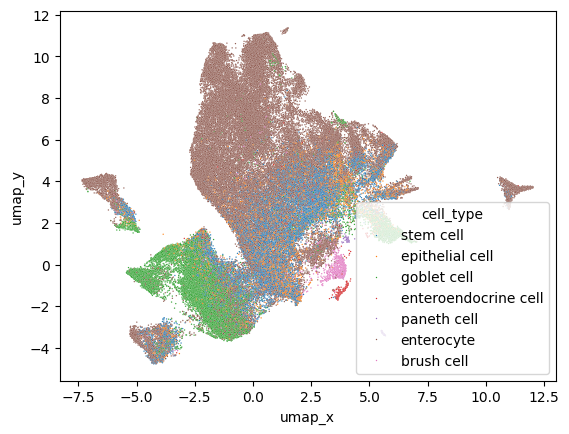

In [9]:
sns.scatterplot(data=df, x="umap_x", y="umap_y", hue="cell_type", s=1)

<Axes: xlabel='umap_x', ylabel='umap_y'>

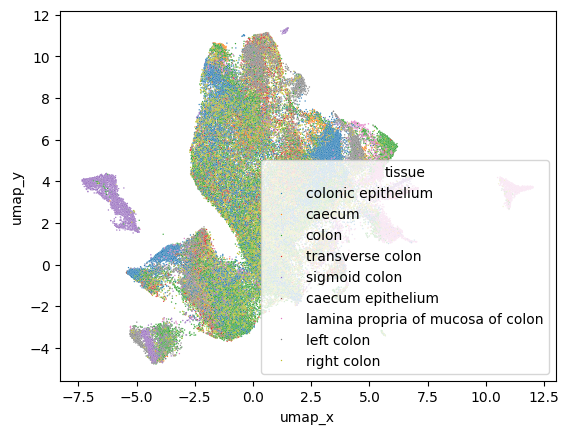

In [10]:
sns.scatterplot(data=df, x="umap_x", y="umap_y", hue="tissue", s=1)